In [ ]:
#HW2: EE559; UB ID: 50432242

#Loading and Intialization

In [ ]:
!pip install cvxpy

In [1]:
#Importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [2]:
mnist = tf.keras.datasets.mnist #loaded data

In [3]:
#Step 1: Loading and Prepocessing data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() #All numbers from 0 to 9
index_train = np.where((train_labels == 2) | (train_labels == 6)) #index of 2 digit and 6 digit which are 3 and 5 in training data (as indexing starts from 0)
index_test = np.where((test_labels == 2) | (test_labels == 6)) #index of 2 digit and 6 digit which are 3 and 5 in test data (as indexing starts from 0)

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
#Extraction training images for 2 and 6
train_images_26 = train_images[index_train]
train_images_26 = train_images_26.reshape((len(train_images_26), train_images_26[1].size))
train_labels_26 = train_labels[index_train].astype('int')

In [5]:
#Extraction test images for 2 and 6
test_images_26 = test_images[index_test]
test_images_26 = test_images_26.reshape((len(test_images_26), test_images_26[1].size))
test_labels_26 = test_labels[index_test].astype('int')

In [6]:
#Changing labels from 2 to -1 and 6 to 1
train_labels_26[np.where(train_labels_26 == 2)] = -1
train_labels_26[np.where(train_labels_26 == 6)] = 1
test_labels_26[np.where(test_labels_26 == 2)] = -1
test_labels_26[np.where(test_labels_26 == 6)] = 1

In [7]:
#Normalizing features
train_images_26 = train_images_26/255
test_images_26 = test_images_26/255

#Whole samples for 5th task
train_images_26_all = train_images_26
test_images_26_all = test_images_26
train_labels_26_all = train_labels_26
test_labels_26_all = test_labels_26

In [8]:
#Extracting first 1000 samples
train_images_26 = train_images_26[range(1000)]
train_labels_26 = train_labels_26[range(1000)]
train_labels_26 = train_labels_26.reshape((np.shape(train_labels_26)[0], 1))

#1. Primal Form

In [9]:
X = train_images_26
Y = train_labels_26

w = cp.Variable((np.shape(train_images_26)[1], 1))
b = cp.Variable((1,1))

#Testing purposes
# print("X shape: ", np.shape(X), type(X))
# print("X shape: ", np.shape(Y), type(Y))
# print("w shape: ", np.shape(w), type(w))

t = X @ w + b

obj = cp.Minimize(cp.sum_squares(w))
constraints = [cp.multiply(Y,t) >= 1]

prob = cp.Problem(obj, constraints)
prob.solve()
print("status:", prob.status)     #status
print("The optimal value", prob.value) #opt value


w = w.value
b = b.value


status: optimal
The optimal value 7.207983941130411


In [10]:
print("w primal shape: ", np.shape(w))
print("b shape: ", np.shape(b))

w primal shape:  (784, 1)
b shape:  (1, 1)


In [12]:
#Calculating accuracy on Training set
train_set_size = train_labels_26.shape[0] #Number of Training Samples
loss = 0
for i in range(train_set_size):
    x = train_images_26[i][:].reshape(784,1) #each xi sample of size (784, 1)
    y = train_labels_26[i] #Actual y-label
    wTx = np.dot(np.transpose(w), x)

    # Activation function
    if wTx + b >= 0:
      y_pred = 1
    else:
      y_pred = -1

    #Loss calculation
    if y*y_pred<=0:
      loss += 1 ##increasing loss value whenever a misclassified label is encountered

error = (1/train_set_size)*loss
accuracy = (1-error)*100
print("Primal form: Training error: {}, Accuracy: {}%".format(error, accuracy))

Primal form: Training error: 0.0, Accuracy: 100.0%


In [13]:
#Calculating accuracy on Test set
test_set_size = test_labels_26.shape[0] #Number of Test Samples
loss = 0
for i in range(test_set_size):
    x = test_images_26[i][:].reshape(784,1) #each xi sample of size (784, 1)
    y = test_labels_26[i] #Actual y-label
    wTx = np.dot(np.transpose(w), x)

    # Activation function
    if wTx + b >= 0:
      y_pred = 1
    else:
      y_pred = -1

    #Loss calculation
    if y*y_pred<=0:
      loss += 1 ##increasing loss value whenever a misclassified label is encountered

error = (1/test_set_size)*loss
accuracy = (1-error)*100
print("Primal form: Test error: {}, Accuracy: {}%".format(error, accuracy))

Primal form: Test error: 0.02462311557788945, Accuracy: 97.53768844221106%


#2. Dual Form

In [14]:
#Dual for w is a vector and b is a scalar

X = train_images_26
Y = train_labels_26


alpha = cp.Variable((np.shape(train_labels_26)[0], 1))
ones = np.ones((np.shape(train_labels_26)[0], 1))

# print("X shape: ", np.shape(X), type(X))
# print("X shape: ", np.shape(Y), type(Y))
# print("alpha shape: ", np.shape(alpha), type(alpha))

obj_fun = -alpha.T @ ones + (1/2)*cp.quad_form(cp.multiply(Y, alpha), X @ X.T)  # (cp.multiply(Y, alpha).T @ (X @ X.T) @ cp.multiply(Y, alpha))

obj = cp.Minimize(obj_fun)
constraints = [alpha >= 0, alpha.T @ Y == 0]

prob = cp.Problem(obj, constraints)
prob.solve()
print("status:", prob.status)     #status
print("The optimal value", prob.value) #opt value

alpha = alpha.value


status: optimal
The optimal value -3.603991970589853


In [16]:
#Calculating w* and b* from alpha
w_dual = np.dot(X.T, alpha*Y)
print("w_dual shape: ", np.shape(w_dual))

y_neg = []
y_pos = []

for i in range(train_set_size):
  if Y[i] == -1:
    y_neg.append(np.dot(w.T, X[i]))
  else:
    y_pos.append(np.dot(w.T, X[i]))

b_dual = - (max(y_neg) + min(y_pos))/2

w = w_dual
b = b_dual

w_dual shape:  (784, 1)


In [20]:
#Calculating accuracy on Training set
train_set_size = train_labels_26.shape[0] #Number of Training Samples
loss = 0
for i in range(train_set_size):
    x = train_images_26[i][:].reshape(784,1) #each xi sample of size (784, 1)
    y = train_labels_26[i] #Actual y-label
    wTx = np.dot(np.transpose(w), x)

    # Activation function
    if wTx + b >= 0:
      y_pred = 1
    else:
      y_pred = -1

    #Loss calculation
    if y*y_pred<=0:
      loss += 1 ##increasing loss value whenever a misclassified label is encountered

error = (1/train_set_size)*loss
accuracy = (1-error)*100
print("Dual form: Training error: {}, Accuracy: {}%".format(error, accuracy))

Dual form: Training error: 0.0, Accuracy: 100.0%


In [21]:
#Calculating accuracy on Test set
test_set_size = test_labels_26.shape[0] #Number of Test Samples
loss = 0
for i in range(test_set_size):
    x = test_images_26[i][:].reshape(784,1) #each xi sample of size (784, 1)
    y = test_labels_26[i] #Actual y-label
    wTx = np.dot(np.transpose(w), x)

    # Activation function
    if wTx + b >= 0:
      y_pred = 1
    else:
      y_pred = -1

    #Loss calculation
    if y*y_pred<=0:
      loss += 1 ##increasing loss value whenever a misclassified label is encountered

error = (1/test_set_size)*loss
accuracy = (1-error)*100
print("Dual form: Test error: {}, Accuracy: {}%".format(error, accuracy))

Dual form: Test error: 0.02462311557788945, Accuracy: 97.53768844221106%


###Observations: From above results of primal form and dual forms of optimal margin classifier, it is evident that the training and test errors are same.

#3. Dual Form using Kernel Trick

In [32]:
#Main idea: replace <x(i), x(j)> with k(x(i), x(j))

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import pairwise_kernels
X = train_images_26
X_test=test_images_26
K_train=rbf_kernel(X,gamma=1) #kernel for training data
K_train_test=rbf_kernel(X,X_test,gamma=1) #kernel for test data

Y = train_labels_26

alpha = cp.Variable((np.shape(train_labels_26)[0], 1))
ones = np.ones((np.shape(train_labels_26)[0], 1))

obj_fun = -alpha.T @ ones + (1/2)*cp.quad_form(cp.multiply(Y, alpha), K_train)  # (cp.multiply(Y, alpha).T @ (X @ X.T) @ cp.multiply(Y, alpha))

obj = cp.Minimize(obj_fun)
constraints = [alpha >= 0, alpha.T @ Y == 0]

prob = cp.Problem(obj, constraints)
prob.solve()
print("status:", prob.status)     #status
print("The optimal value", prob.value) #opt value

alpha = alpha.value



status: optimal
The optimal value -499.8341660174252


In [28]:
#Dual SVM using kernel trick
#Calculating w* and b* from alpha
w_dual_pix = np.dot(K_train.T, alpha*Y)

y_neg = []
y_pos = []
loss = 0

for i in range(train_set_size):
  if Y[i] == -1:
    y_neg.append(w_dual_pix[i])
  else:
    y_pos.append(w_dual_pix[i])

b_dual = - (max(y_neg) + min(y_pos))/2


#Training error
y_pred = w_dual_pix + b_dual

y_pred = [1 if y >= 0 else -1 for y in y_pred]


for i in range(train_set_size):
  if Y[i] != y_pred[i]:
    loss += 1


error = (1/train_set_size)*loss
accuracy = (1-error)*100
print("Dual SVM with kernel: ")
print("Training error: {}, Accuracy: {}%".format(error, accuracy))

Dual SVM with kernel: 
Training error: 0.0, Accuracy: 100.0%


In [29]:
#Dual SVM using kernel trick: Test error
#Calculating w* and b* from alpha

w_dual_pix = np.dot(K_train_test.T, alpha*Y)

y_test = test_labels_26
y_neg = []
y_pos = []
loss = 0

for i in range(test_set_size):
  if y_test[i] == -1:
    y_neg.append(w_dual_pix[i])
  else:
    y_pos.append(w_dual_pix[i])

b_dual = - (max(y_neg) + min(y_pos))/2


#Test error
y_pred = w_dual_pix + b_dual

y_pred = [1 if y >= 0 else -1 for y in y_pred]

for i in range(test_set_size):
  if y_test[i] != y_pred[i]:
    loss += 1


error = (1/test_set_size)*loss
accuracy = (1-error)*100
print("Dual SVM with kernel: ")
print("Test error: {}, Accuracy: {}%".format(error, accuracy))

Dual SVM with kernel: 
Test error: 0.2718592964824121, Accuracy: 72.8140703517588%


###Observation: Dual SVM with kernel trick shows a less accuracy on test data. Better results can be obtained by trying different sigma values

#4. Comparison

###K-nearest neighbor algorithm

In [31]:
#for k = [3,5]
#Training set
kvalues = [3,5]
for k in kvalues: #Iterating over different k values
  loss = 0
  for i in range(train_set_size): #Calculating Euclieden distance values for each sample of training data
    distance = []
    x = train_images_26[i][:].reshape(784,1)
    y = train_labels_26[i]
    for j in range(train_set_size): #Calculating Euclieden distance from each sample of training data to every sample of training data
        x1 = train_images_26[j][:].reshape(784,1)
        d = np.linalg.norm(x-x1) #Calculating the euclidean distance
        distance.append(d)

    sorteddistance = list(np.argsort(distance)) #Sorting the distance in ascending order

    # if k == 1: #for k = 1
    #   y_pred = train_labels_26_w_dummy[sorteddistance[0]] #Using only first minimum sample from sorted distances

    if k == 3: #for K = 3
      ylabels = []
      for i in range(3): #Using first 3 minimum distance samples from sorted distances
        ylabels.append(train_labels_26[sorteddistance[i]])
      y_pred = max(ylabels, key = ylabels.count)

    if k == 5: #for K = 5
      ylabels = []
      for i in range(5):#Using first 5 minimum distance samples from sorted distances
        ylabels.append(train_labels_26[sorteddistance[i]])
      y_pred = max(ylabels, key = ylabels.count)

    #Loss function
    if y != y_pred:
        loss += 1 #increasing loss value whenever a misclassified label is encountered

  error = (1/train_set_size)*loss
  accuracy = (1-error)*100
  print("K: {}, Training error: {}".format(k, error))

#K-nearest neighbor algorithm
#Test set
for k in kvalues:
  loss = 0
  for i in range(test_set_size): #Calculating Euclieden distance values for each sample of test data
    distance = []
    x = test_images_26[i][:].reshape(784,1)
    y = test_labels_26[i]
    for j in range(train_set_size):
        x1 = train_images_26[j][:].reshape(784,1)
        d = np.linalg.norm(x-x1) #Calculating the euclidean distance
        distance.append(d)

    sorteddistance = list(np.argsort(distance)) #Sorting the distance in ascending order

    if k == 1: #for k = 1 #First minimum distances from training samples
      y_pred = train_labels_26[sorteddistance[0]] #Getting the y-label of closest neighbour

    if k == 3: #for K = 3 #First 3 minimum distances from training samples
      ylabels = []
      for i in range(3):
        ylabels.append(train_labels_26[sorteddistance[i]]) #y labels of 3 training samples
      y_pred = max(ylabels, key = ylabels.count) #Getting the maximum repeated y-label of closest 3 neighbours

    if k == 5: #for K = 5 #First 5 minimum distances from training samples
      ylabels = []
      for i in range(5):
        ylabels.append(train_labels_26[sorteddistance[i]]) #y labels of 5 training samples
      y_pred = max(ylabels, key = ylabels.count)#Getting the maximum repeated y-label of closest 5 neighbours

    #Loss function
    if y != y_pred:
        loss += 1 #increasing loss value whenever a misclassified label is encountered

  error = (1/test_set_size)*loss
  accuracy = (1-error)*100
  print("K: {}, Test error: {}".format(k, error))

K: 3, Training error: 0.002
K: 5, Training error: 0.006
K: 3, Test error: 0.006030150753768845
K: 5, Test error: 0.007035175879396985


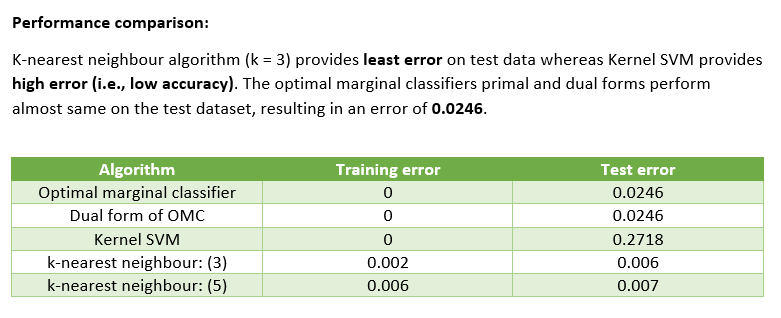